Evaluates the performance gains from our internal modifications to the vllm engine. Compares to `ReferenceLLM`, which does not modify the vllm engine internally. 

Note that the reference model is synchronous---this should actually provide it an advantage in the comparison since there is no async overhead. 

In [1]:
import nest_asyncio
nest_asyncio.apply()

In [2]:
import asyncio
from tqdm.notebook import tqdm
from arsenal.timer import Timer
from viztracer import VizTracer
from async_llm.llm import AsyncLLM, ReferenceLLM

In [3]:
model_name = 'gpt2'

async_llm = AsyncLLM.from_name(
    model_name, engine_opts={'gpu_memory_utilization' : 0.45}
)

reference_llm = ReferenceLLM.from_name(
    model_name, llm_opts={'gpu_memory_utilization' : 0.45}
)

INFO 12-19 12:50:54 config.py:2167] Downcasting torch.float32 to torch.float16.
INFO 12-19 12:51:21 config.py:478] This model supports multiple tasks: {'score', 'classify', 'reward', 'generate', 'embed'}. Defaulting to 'generate'.
INFO 12-19 12:51:21 llm_engine.py:249] Initializing an LLM engine (v0.6.5) with config: model='gpt2', speculative_config=None, tokenizer='gpt2', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=1024, download_dir=None, load_format=auto, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto, quantization_param_path=None, device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='xgrammar'), observability_config=ObservabilityConfig(otlp_traces_endpoint=None, collect_model_forward_time=False, collect_model_execute_time=False), seed=0,

Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


INFO 12-19 12:51:27 model_runner.py:1097] Loading model weights took 0.2378 GB
INFO 12-19 12:51:28 worker.py:241] Memory profiling takes 0.65 seconds
INFO 12-19 12:51:28 worker.py:241] the current vLLM instance can use total_gpu_memory (79.44GiB) x gpu_memory_utilization (0.45) = 35.75GiB
INFO 12-19 12:51:28 worker.py:241] model weights take 0.24GiB; non_torch_memory takes 0.12GiB; PyTorch activation peak memory takes 0.47GiB; the rest of the memory reserved for KV Cache is 34.92GiB.
INFO 12-19 12:51:28 gpu_executor.py:76] # GPU blocks: 63576, # CPU blocks: 7281
INFO 12-19 12:51:28 gpu_executor.py:80] Maximum concurrency for 1024 tokens per request: 993.38x
INFO 12-19 12:51:31 model_runner.py:1413] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI.
INFO 12-19 12:51:31 model_runner.py:1417] If out-of-memory error occurs during cudagraph captu

Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


INFO 12-19 12:51:54 model_runner.py:1097] Loading model weights took 0.2440 GB
INFO 12-19 12:51:54 worker.py:241] Memory profiling takes 0.38 seconds
INFO 12-19 12:51:54 worker.py:241] the current vLLM instance can use total_gpu_memory (79.44GiB) x gpu_memory_utilization (0.45) = 35.75GiB
INFO 12-19 12:51:54 worker.py:241] model weights take 0.24GiB; non_torch_memory takes -0.02GiB; PyTorch activation peak memory takes 0.46GiB; the rest of the memory reserved for KV Cache is 35.06GiB.
INFO 12-19 12:51:54 gpu_executor.py:76] # GPU blocks: 63818, # CPU blocks: 7281
INFO 12-19 12:51:54 gpu_executor.py:80] Maximum concurrency for 1024 tokens per request: 997.16x
INFO 12-19 12:51:57 model_runner.py:1413] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI.
INFO 12-19 12:51:57 model_runner.py:1417] If out-of-memory error occurs during cudagraph capt

In [9]:
from util import get_wikitext, token_prefixes
text = get_wikitext()
prefixes = token_prefixes(text[:1000], async_llm.tokenizer)

In [11]:
async_timer = Timer('async_llm')
reference_timer = Timer('reference_llm')

for token_ids in tqdm(prefixes):
    with async_timer(len=len(token_ids)):
        logprobs = await async_llm.next_token_logprobs(token_ids)
    with reference_timer(len=len(token_ids)):
        logprobs = reference_llm.next_token_logprobs(token_ids)

0it [00:00, ?it/s]

In [41]:
async_timer.compare(reference_timer)

async_llm is 16.7738x faster than reference_llm (p=0.00000, median: reference_llm: 0.148057, async_llm: 0.00882673)


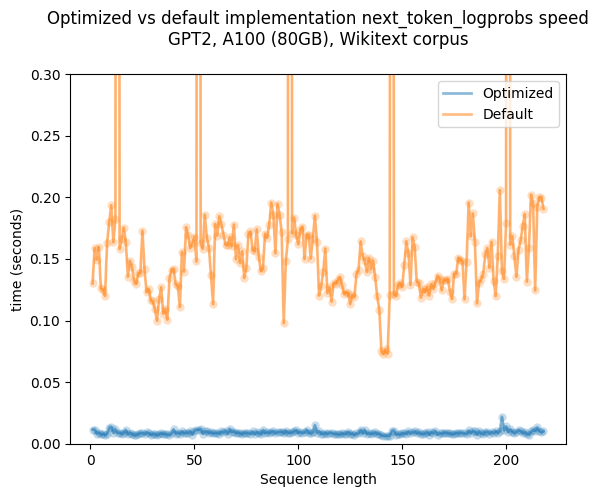

In [40]:
ax = async_timer.plot_feature('len', label='Optimized')
ax = reference_timer.plot_feature('len', ax=ax, label='Default')
ax.set_ylim(0,0.3)
ax.set_xlabel('Sequence length')
ax.set_title(
    'Optimized vs default implementation next_token_logprobs speed\n'
    'GPT2, A100 (80GB), Wikitext corpus\n'
)
ax.legend()